In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection
from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"


# Pics of branches for multiple values of Kegl

In [2]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.005
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.52631578947368


initialised ...


In [3]:
def get_all_stim_freqs(delay):
    ''' System Frequency is function of delay can be approximated in two ways
    1. (synchroinzation_state + 1) x Period + 50 = 2 x delay 
    2. synchroniation_state x Period = 2 * delay 
    The second is a little worse but fits better to my theory.'''
    def method_one(state, sys_delay):
        period = (sys_delay+50) / (state+1)  
        return 1000 / period
    
    def method_two(state, sys_delay):
        if state == 0:
            period = sys_delay / (state+1)
        else:
            period = sys_delay / state
        period += 1
        return 1000 / period 

    ret = []
    for i in range(7):
        if i % 2 == 0:
            ret.append(('in', method_one(state = i, sys_delay= 2 * delay)))
        else:
            ret.append(('anti', method_one(state = i, sys_delay= 2 * delay)))
    
    return ret

In [4]:
SP_WINDOW = 100

def evalf(traj):
    pars = search.getParametersFromTraj(traj)

    aln.params['signalV'] = pars['signalV']
    aln.params['Ke_gl'] = pars['Ke_gl']
    
    # calc absolute interareal delay
    delay = aln.params.lengthMat[0,1] / aln.params.signalV
    
    sfreqs = get_all_stim_freqs(delay)
    freqs = np.ndarray((len(sfreqs)))
    shifts = np.ndarray((len(sfreqs)))
    
    for i, sfreq in enumerate(sfreqs):
        stim_type = sfreq[0]
        stim_freq = sfreq[1]
        
        if stim_type == 'anti':
            stimulus = construct_antiphase_stimulus(stim_bias = 0, 
                                       duration = aln.params.duration, 
                                       dt = aln.params.dt, 
                                       stim_freq_anti = int(stim_freq), 
                                       n_periods_anti = int(2*stim_freq),
                                       stim_amp = 0.4, 
                                       nostim_before = 0,
                                       nostim_after = aln.params.duration,
                                       decay=True)
        elif stim_type == 'in':
            stimulus = construct_inphase_stimulus(stim_bias = 0, 
                                       duration = aln.params.duration, 
                                       dt = aln.params.dt, 
                                       stim_freq_in = int(stim_freq), 
                                       n_periods_in = int(2*stim_freq),
                                       stim_amp = 0.4, 
                                       nostim_before = 0,
                                       nostim_after = aln.params.duration,
                                       decay=True)
        else:
            print("Stim type not defined:")
            results_dict = {}
            search.saveOutputsToPypet(result_dict, traj)
            return
        
        aln.params['ext_exc_current'] = stimulus
        aln.randomICs()
        aln.run()
        
        # Evaluation
        stage = aln['rates_exc'][:, int(5000/aln.params.dt) :]
        stim_shift = phase_shift(stage[0], stage[1], duration=10000, dt=aln.params.dt)
        domfreq = dom_frequency(stage[0],
                            dt=aln.params['dt'],
                            SP_WINDOW=SP_WINDOW)
        
        shifts[i] = stim_shift[0] # stim_shift in [0,1]
        freqs[i] = domfreq
        
        
        
    result_dict = {"delay" : delay, 
                   #"sfreq" : sfreqs[1],
                   "shifts" : shifts,
                   "frequencies" : freqs}   
        
    search.saveToPypet(result_dict, traj)
    return

In [5]:
Cmat = np.ones((2,2))
np.fill_diagonal(Cmat, 0)
Dmat = Cmat.copy()
Dmat *= 50 

aln = ALNModel(Cmat = Cmat, Dmat = Dmat)
# Put ALN in "A3" Point right inside the LC_EI
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5

# no adaptation 
aln.params['a'] = 0.
aln.params['b'] = 0. 

aln.params['sigma_ou'] = 0.

aln.params['dt'] = 0.005

aln.params['duration'] = 30 * 1000 

INFO:root:aln: Model initialized.


In [6]:
def delayToVelocity(delay, distance=50):
    '''delay in my, distance in mm'''
    return distance / delay

delay = np.arange(0, 140, 1)
Kegl = np.asarray( [50, 100, 300, 700, 1500] )

#delay = np.asarray([1])
#Kegl = np.asarray([1])
signalV = delayToVelocity(delay)

parameters = ParameterSpace({"signalV": signalV,
                             "Ke_gl": Kegl})
#parameters = ParameterSpace({"signalV": [1],
#                             "Ke_gl": [100]})
search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   filename=HDF_PATH+'Clean_TwoNode_periods_dgl,Kegl.hdf',
                   ncores=4)

INFO:root:Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Clean_TwoNode_periods_dgl,Kegl.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 700
MainProcess root INFO     BoxSearch: Environment initialized.


In [7]:
#search.run()

In [8]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/Clean_TwoNode_periods_dgl,Kegl.hdf
MainProcess root INFO     Analyzing trajectory results-2021-11-23-11H-24M-00S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/Clean_TwoNode_periods_dgl,Kegl.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-11-23-11H-24M-00S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 700/700 [00:05<00:00, 134.78it/s]
MainProcess root INFO     All results loaded.


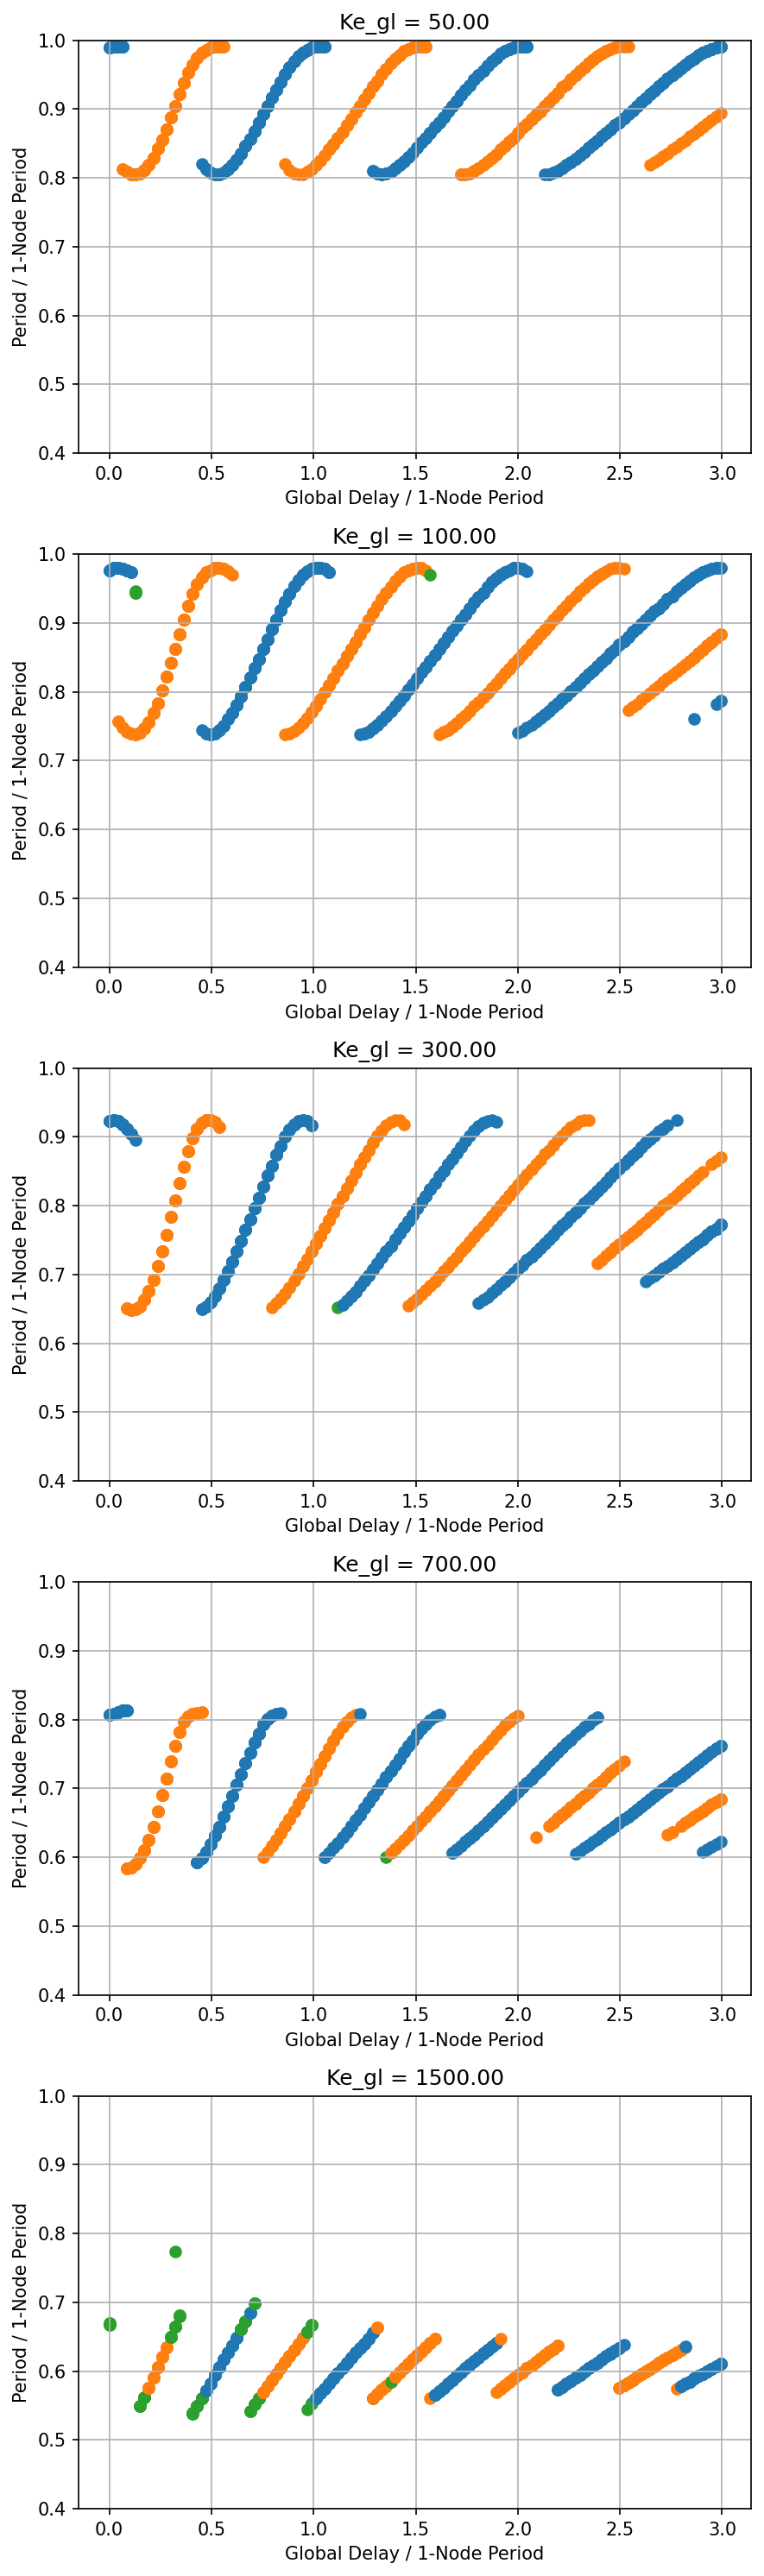

In [9]:
st_period = prc.frperiod

Kes = search.dfResults.Ke_gl.drop_duplicates()
fig, axs = plt.subplots(len(Kes),1, figsize=(6, 20), dpi=150)
for k, ke in enumerate(Kes):
    ax = axs[k]
    df = search.dfResults[search.dfResults.Ke_gl == ke]
    for i in df.index:
        for j in range(7):
            if np.isclose(np.abs(df.shifts[i][j]), 1, atol=0.1): 
                ax.scatter(df.delay[i] / st_period , 1000/df.frequencies[i][j] / st_period, c = "tab:orange")
            elif np.isclose(np.abs(df.shifts[i][j]), 0, atol=0.1):
                ax.scatter(df.delay[i] / st_period, 1000/df.frequencies[i][j] / st_period, c = "tab:blue")
            else:
                ax.scatter(df.delay[i] / st_period, 1000/df.frequencies[i][j]/st_period, c = "tab:green")


        #ax.scatter(df.delay[i], df.period1[i], c = "tab:orange" if np.isclose(df.state1[i], 1, atol=0.2) else "tab:blue")
        #ax.scatter(df.delay[i], df.period2[i], c = "tab:orange" if np.isclose(df.state2[i], 1, atol=0.2) else "tab:blue")
        #ax.scatter(df.delay[i], df.period3[i], c = "tab:orange" if np.isclose(df.state3[i], 1, atol=0.2) else "tab:blue")
    #for delay in range(122):
    #    s = get_all_stim_freqs(delay)
    #    for i, freq in enumerate(s):
    #        plt.scatter(delay / st_period, 1000 / freq[1] / st_period, s=0.5, color="orange" if (i%2!=0) else "blue")

    #ax.axhline(1, color="black")
    #ax.axhline(0.605, color="black")

    #ax.axhline(0.6 * (1000/ 19.25))
    #ax.set_ylim(0.5, 1.1)
    ax.set_title("Ke_gl = {0:.2f}".format(ke))
    ax.set_xlabel("Global Delay / 1-Node Period")
    ax.set_ylabel("Period / 1-Node Period")
    ax.grid()
    ax.set_ylim(0.4, 1.0)
fig.tight_layout()

In [10]:
from matplotlib.lines import Line2D

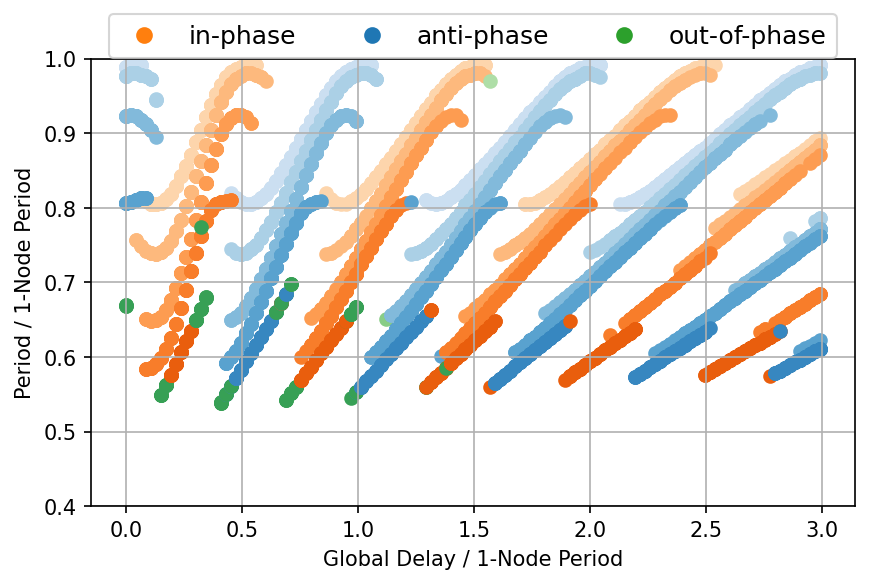

In [11]:
def legend_without_duplicate_labels(ax):
    circ1 = Line2D([0], [0], linestyle="none", marker="o", color="tab:orange", markersize=7, markerfacecolor="tab:orange")
    circ2 = Line2D([0], [0], linestyle="none", marker="o", color="tab:blue", markersize=7, markerfacecolor="tab:blue")
    circ3 = Line2D([0], [0], linestyle="none", marker="o", color="tab:green", markersize=7, markerfacecolor="tab:green")

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    handles = [circ1, circ2, circ3]
    ax.legend(handles, labels, bbox_to_anchor=(0.5, 1.05), loc="center", ncol=4, fontsize=12)
    

Kes = search.dfResults.Ke_gl.drop_duplicates()
fig, ax = plt.subplots(dpi=150)

cmap = plt.get_cmap('Oranges', 10)
cmap_b = plt.get_cmap('Blues', 10)
cmap_g = plt.get_cmap('Greens', 10)

for k, ke in enumerate(Kes):
    alpha = 0.2*(k+1)
    df = search.dfResults[search.dfResults.Ke_gl == ke]
    for i in df.index:
        for j in range(7):
            if np.isclose(np.abs(df.shifts[i][j]), 1, atol=0.3): 
                ax.scatter(df.delay[i] / st_period , 1000/df.frequencies[i][j] / st_period, color=cmap(k+2), alpha=1, label="anti-phase")
            elif np.isclose(np.abs(df.shifts[i][j]), 0, atol=0.3):
                ax.scatter(df.delay[i] / st_period, 1000/df.frequencies[i][j] / st_period, color=cmap_b(k+2),alpha=1, label="in-phase")
            else:
                ax.scatter(df.delay[i] / st_period, 1000/df.frequencies[i][j]/st_period, color=cmap_g(k+2), alpha=1, label="out-of-phase")


        #ax.scatter(df.delay[i], df.period1[i], c = "tab:orange" if np.isclose(df.state1[i], 1, atol=0.2) else "tab:blue")
        #ax.scatter(df.delay[i], df.period2[i], c = "tab:orange" if np.isclose(df.state2[i], 1, atol=0.2) else "tab:blue")
        #ax.scatter(df.delay[i], df.period3[i], c = "tab:orange" if np.isclose(df.state3[i], 1, atol=0.2) else "tab:blue")
    #for delay in range(122):
    #    s = get_all_stim_freqs(delay)
    #    for i, freq in enumerate(s):
    #        plt.scatter(delay / st_period, 1000 / freq[1] / st_period, s=0.5, color="orange" if (i%2!=0) else "blue")

    #ax.axhline(1, color="black")
    #ax.axhline(0.605, color="black")

    #ax.axhline(0.6 * (1000/ 19.25))
    #ax.set_ylim(0.5, 1.1)
#ax.set_title("Ke_gl = {0:.2f}".format(ke))
legend_without_duplicate_labels(ax)
ax.set_xlabel("Global Delay / 1-Node Period")
ax.set_ylabel("Period / 1-Node Period")
ax.grid()
ax.set_ylim(0.4, 1.0)
fig.tight_layout()

## now in my style

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

[ 0.5  1.5  2.5  7.5  8.5 13.5]
[ 0.5  1.5  2.5  7.5  8.5 13.5]


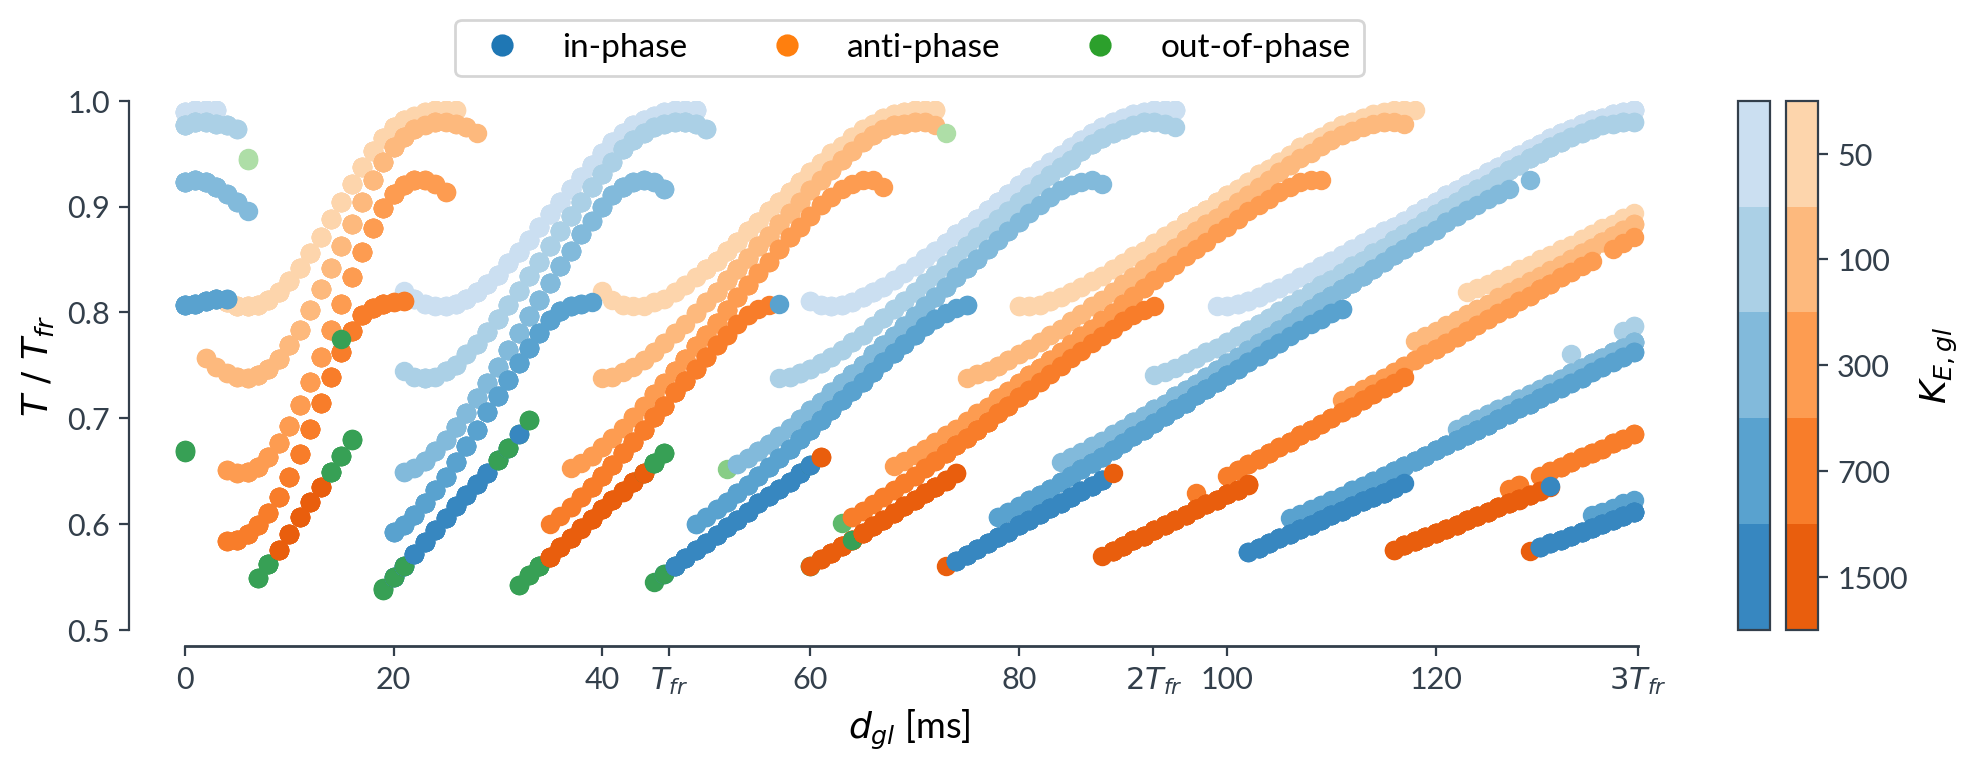

In [14]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13


def legend_without_duplicate_labels(ax):
    circ1 = Line2D([0], [0], linestyle="none", marker="o", color="tab:blue", markersize=7, markerfacecolor="tab:blue")
    circ2 = Line2D([0], [0], linestyle="none", marker="o", color="tab:orange", markersize=7, markerfacecolor="tab:orange")
    circ3 = Line2D([0], [0], linestyle="none", marker="o", color="tab:green", markersize=7, markerfacecolor="tab:green")

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    handles = [circ1, circ2, circ3]
    ax.legend(handles, labels, bbox_to_anchor=(0.5, 1.1), loc="center", ncol=4, fontsize=12)
    
    
fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=200, sharex=True)

ax1_divider = make_axes_locatable(ax)

Kes = search.dfResults.Ke_gl.drop_duplicates()

cmap = plt.get_cmap('Oranges', 10)
newcolors = cmap(np.linspace(0, 1, 10))
newcolors = newcolors[2:8]
cmap = ListedColormap(newcolors)

cmap_b = plt.get_cmap('Blues', 10)
newcolors = cmap_b(np.linspace(0, 1, 10))
newcolors = newcolors[2:8]
cmap_b = ListedColormap(newcolors)
cmap_g = plt.get_cmap('Greens', 10)

for k, ke in enumerate(Kes):
    #if not k%10 == 0:
    #    continue
    df = search.dfResults[search.dfResults.Ke_gl == ke]
    for i in df.index:
        for j in range(7):
            if np.isclose(np.abs(df.shifts[i][j]), 1, atol=0.1): 
                ax.scatter(df.delay[i] , 1000/df.frequencies[i][j] / st_period, color=cmap(k), alpha=1, label="anti-phase")
            elif np.isclose(np.abs(df.shifts[i][j]), 0, atol=0.1):
                ax.scatter(df.delay[i] , 1000/df.frequencies[i][j] / st_period, color=cmap_b(k),alpha=1, label="in-phase")
            else:
                ax.scatter(df.delay[i] , 1000/df.frequencies[i][j]/st_period, color=cmap_g(k+2), alpha=1, label="out-of-phase")

                
####### cax blue 
col_dict={1:"blue",
          2:"red",
          13:"orange",
          7:"green",
          8:"red"}

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)

labels = np.array(["","","","",""])
len_lab = len(labels)

norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_b)
#cax = plt.colorbar(mappable)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cax1 = ax1_divider.append_axes("right", size="2%", pad="2%")
cb = fig.colorbar(mappable, format=fmt, ticks=tickz, cax=cax1)
cax1.invert_yaxis() 
cax1.tick_params(right=False, top=False)
cax1.set_ylabel("")
cax1.set_yticklabels("")

####### cax orange 
col_dict={1:"blue",
          2:"red",
          13:"orange",
          7:"green",
          8:"red"}

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
print(norm_bins)

labels = np.array(["50", "100", "300", "700", "1500"])
len_lab = len(labels)

norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
#cax = plt.colorbar(mappable)

diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cax2 = ax1_divider.append_axes("right", size="2%", pad="1%")
cb = fig.colorbar(mappable, format=fmt, ticks=tickz, cax=cax2)
cax2.invert_yaxis() 
cax2.set_ylabel(r"$K_{E, gl}$")

######## major axis
ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

ax.spines["left"].set_bounds(low=0.5, high=1)
ax.spines["left"].set_position(("outward", -6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))

ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0','20','40','60','80','100','120', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])

legend_without_duplicate_labels(ax)
ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")
#ax.grid()
ax.set_ylim(0.5, 1.0)
fig.tight_layout()

#fig.savefig("Pics/Two_Node_Periods_all_K.pdf")

In [3]:
import os
import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

import logging
import tqdm

from scipy import stats

In [4]:
# from neurolib.utils.functions
def construct_stimulus(
    stim="dc",
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq=1,
    stim_bias=0,
    n_periods=None,
    nostim_before=0,
    nostim_after=0,
):
    """Constructs a stimulus that can be applied to a model

    :param stim: Stimulation type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection, defaults to 'dc'
    :type stim: str, optional
    :param duration: Duration of stimulus in ms, defaults to 6000
    :type duration: int, optional
    :param dt: Integration time step in ms, defaults to 0.1
    :type dt: float, optional
    :param stim_amp: Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA), defaults to 0.2
    :type stim_amp: float, optional
    :param stim_freq: Stimulation frequency, defaults to 1
    :type stim_freq: int, optional
    :param stim_bias: Stimulation offset (bias), defaults to 0
    :type stim_bias: int, optional
    :param n_periods: Numer of periods of stimulus, defaults to None
    :type n_periods: [type], optional
    :param nostim_before: Time before stimulation, defaults to 0
    :type nostim_before: int, optional
    :param nostim_after: Time after stimulation, defaults to 0
    :type nostim_after: int, optional
    :raises ValueError: Raises error if unsupported stimulus type is chosen.
    :return: Stimulus timeseries
    :rtype: numpy.ndarray
    """
    """Constructs a sitmulus that can be applied as input to a model

    TODO: rewrite

    stim:       Stimulus type: 'ac':oscillatory stimulus, 'dc': stimple step current, 
                'rect': step current in negative then positive direction with slowly
                decaying amplitude, used for bistability detection
    stim_amp:   Amplitude of stimulus (for AdEx: in mV/ms, multiply by conductance C to get current in pA)
    """
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)

    if stim == "ac":
        """Oscillatory stimulus
        """
        n_periods = n_periods or int(stim_freq)

        stimulus = np.hstack(
            ([stim_bias] * int(nostim_before / dt), np.tile(sinus_stim(stim_freq, stim_amp) + stim_bias, n_periods),)
        )
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
    elif stim == "dc":
        """Simple DC input and return to baseline
        """
        stimulus = np.hstack(([stim_bias] * int(nostim_before / dt), [stim_bias + stim_amp] * int(1000 / dt)))
        stimulus = np.hstack((stimulus, [stim_bias] * int(nostim_after / dt)))
        stimulus[stimulus < 0] = 0
    elif stim == "rect":
        """Rectified step current with slow decay
        """
        # construct input
        stimulus = np.zeros(int(duration / dt))
        tot_len = int(duration / dt)
        stim_epoch = tot_len / 6

        stim_increase_counter = 0
        stim_decrease_counter = 0
        stim_step_increase = 5.0 / stim_epoch

        for i, m in enumerate(stimulus):
            if 0 * stim_epoch <= i < 0.5 * stim_epoch:
                stimulus[i] -= stim_amp
            elif 0.5 * stim_epoch <= i < 3.0 * stim_epoch:
                stimulus[i] = -np.exp(-stim_increase_counter) * stim_amp
                stim_increase_counter += stim_step_increase
            elif 3.0 * stim_epoch <= i < 3.5 * stim_epoch:
                stimulus[i] += stim_amp
            elif 3.5 * stim_epoch <= i < 5 * stim_epoch:
                stimulus[i] = np.exp(-stim_decrease_counter) * stim_amp
                stim_decrease_counter += stim_step_increase
    else:
        raise ValueError(f'Stimulus {stim} not found. Use "ac", "dc" or "rect".')

    # repeat stimulus until full length
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    print(stimlength)
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus

def construct_inphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_bias=0,
    n_periods_in=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_after / dt))) #could make variable nostim_between if necessary
    
        
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus,int(steps / stimlength + 2))
    stimulus = stimulus[:steps]

    return stimulus
 
def construct_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = -stimulus + 2*stim_bias
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 
def construct_inphase_antiphase_stimulus(   
    duration=6000,
    dt=0.1,
    stim_amp=0.2,
    stim_freq_in=1,
    stim_freq_anti=2,
    stim_bias=0,
    n_periods_in=None,
    n_periods_anti=None,
    nostim_before=0,
    nostim_after=0,
    nostim_between=0,
    decay=False
):
    def sinus_stim(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        return np.tile(sinus_function, cycles)
    
    def sinus_stim_decay(f=1, amplitude=0.2, positive=0, phase=0, cycles=1, t_pause=0):
        x = np.linspace(np.pi, -np.pi, int(1000 / dt / f))
        sinus_function = np.hstack(((np.sin(x + phase) + positive), np.tile(0, t_pause)))
        sinus_function *= amplitude
        stim = np.tile(sinus_function, cycles)

        decay_len = len(stim) / 6 # should decay to 1 / 6e
        stim_decrease_counter = 0
        stim_step_increase = 1/decay_len
        for i, m in enumerate(stim):
            if i < len(stim)/2:
                pass
            else:
                stim[i] *= np.exp(-stim_decrease_counter) 
                stim_decrease_counter += stim_step_increase
        return stim
    
    # create two stimuli and then hstack
    #### IN-PHASE STIMULUS
    n_periods_in = n_periods_in or int(stim_freq_in)
        
    if decay:
        oscillation_in_phase = sinus_stim_decay(stim_freq_in, stim_amp, cycles = n_periods_in)
    else:
        oscillation_in_phase = sinus_stim(stim_freq_in, stim_amp, cycles = n_periods_in)

    stimulus_in_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_in_phase + stim_bias)
    ) 
    stimulus_in_phase = np.hstack((stimulus_in_phase, [stim_bias] * int(nostim_between / dt))) #could make variable nostim_between if necessary
    
    ### ANTI-PHASE STIMULUS
    n_periods_anti = n_periods_anti or int(stim_freq_anti)
    
    if decay:
        oscillation_anti = sinus_stim_decay(stim_freq_anti, stim_amp, cycles = n_periods_anti)
    else:
        oscillation_anti = sinus_stim(stim_freq_anti, stim_amp, cycles = n_periods_anti)

    stimulus_anti_phase = np.hstack(
        ([stim_bias] * int(nostim_before / dt), oscillation_anti + stim_bias)
    )
    stimulus_anti_phase = np.hstack((stimulus_anti_phase, [stim_bias] * int(nostim_after / dt)))
    

    stimulus = np.hstack((stimulus_in_phase, stimulus_anti_phase))
    stimulus_anti = np.hstack((stimulus_in_phase, -stimulus_anti_phase + 2*stim_bias))
    
    steps = int(duration / dt)
    stimlength = int(len(stimulus))
    stimulus = np.tile(stimulus, int(steps / stimlength + 2))
    stimulus = stimulus[:steps]
    stimulus_anti = np.tile(stimulus_anti, int(steps / stimlength + 2))
    stimulus_anti = stimulus_anti[:steps]
    
    stimuli = np.ndarray( (2, int(duration / dt)) )
    stimuli[0] = stimulus
    stimuli[1] = stimulus_anti
    return stimulus, stimulus_anti
 